In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
GPU_ID= '0'
os.environ["CUDA_VISIBLE_DEVICES"] =GPU_ID
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import MiniBatchKMeans
import os
from sklearn.svm import SVC
import pickle
import matplotlib
from matplotlib import pyplot
from PIL import Image

In [5]:
def makeVocabulary(folder_name, batch_size = 10):
    all_pixels = []
    total_images = 0
    kmeans = MiniBatchKMeans(n_clusters = 50, random_state = 0, max_iter=300, n_init=10)
    for season in os.listdir(folder_name+"/"):
        for filename in os.listdir(folder_name+"/"+season):
            dat = np.load(folder_name+"/"+season+"/"+filename)
            total_images += 1
            for x_index in range(0, len(dat)):
                for y_index in range(0, len(dat[x_index])):
                    all_pixels.append(np.divide(dat[x_index][y_index][0:3],10000))
            if(total_images % batch_size == 0):
                kmeans = kmeans.partial_fit(all_pixels)
                all_pixels = []
                print("Done with batch")
                
    if(total_images % batch_size != 0):
        kmeans = kmeans.partial_fit(all_pixels)
        print("**Done with all batches**")
    
    return kmeans



def predict(vocabulary, file_name, model, nclusters = 20):
    NUM_CLASSES=100
    dat = np.load(file_name)
    image_pixels = []
    for x_index in range(0, len(dat)):
        for y_index in range(0, len(dat[x_index])):
            image_pixels.append(np.divide(dat[x_index][y_index][0:3],10000))
    
    kmeans = MiniBatchKMeans(n_clusters=nclusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_predictions = kmeans.fit_predict(image_pixels)
    cluster_histograms = []
    
    for i in range(0, nclusters):
        histogram = [0]*vocabulary.n_clusters
        cluster_histograms.append(histogram)
    pixel_no = 0
    for x_index in range(0, len(dat)):
        for y_index in range(0, len(dat[x_index])):
            cluster_point = vocabulary.predict(np.array([np.divide(dat[x_index][y_index][0:3],10000)]))[0]
            cluster_histograms[cluster_predictions[pixel_no]][cluster_point] += 1
            pixel_no += 1
    
    landcover = np.zeros((256, 256), dtype=float)
    histo_classes=[]
    
    for i in range(0, nclusters):
        input_hist = []
        normalized_histogram = np.divide(cluster_histograms[i], sum(cluster_histograms[i]))
        input_hist.append(normalized_histogram)
        input_hist=np.array(input_hist)
        predicted_class = model.predict(input_hist)
        histo_classes.append(predicted_class)
    
    pixel_no = 0
    for x_index in range(0, len(landcover)):
        for y_index in range(0, len(landcover[x_index])):
            landcover[x_index][y_index] = histo_classes[cluster_predictions[pixel_no]]
            pixel_no += 1
    
    return landcover

def predict_highlc(filename):   
    with open('model_vocabulary.pkl', 'rb') as f:
        vocab = pickle.load(f)
        
    with open('HISTO-CLASS_model.pkl', 'rb') as f:
        clf = pickle.load(f)
    
    lc = predict(vocab,filename,clf)
    return lc

In [8]:
filename="..\SEN12MS\processed\ROIs13_high_roshan_s2_val_patches\ROIs13_high_roshan\s2_1\ROIs0000_validation_s2_0_p0.npy"
landcover = predict_highlc(filename)

In [9]:
print(type(landcover))

<class 'numpy.ndarray'>


In [10]:
"""landcover[landcover == 1] = 0# forest
landcover[landcover == 2] = 0
landcover[landcover == 3] = 0
landcover[landcover == 4] = 0
landcover[landcover == 5] = 0
landcover[landcover == 6] = 1  # shrublands
landcover[landcover == 7] = 1
landcover[landcover == 8] = np.random.choice(np.arange(0, 8), p=[0.15, 0.05, 0.15, 0, 0, 0.15, 0.5, 0])  # savannas
landcover[landcover == 9] = np.random.choice(np.arange(0, 8), p=[0.15, 0.05, 0.15, 0, 0, 0.15, 0.5, 0])
landcover[landcover == 10] = 3  # grassland
landcover[landcover == 11] = 4  # wetlands
landcover[landcover == 12] = 5  # croplands
landcover[landcover == 13] = 6  # builtup
landcover[landcover == 14] = 5  # cropland
landcover[landcover == 15] = 7  # ice
landcover[landcover == 16] = 6  # barren
landcover[landcover == 17] = 7  # water"""
landcover[landcover == 1] = 0
landcover[landcover == 2] = 1
landcover[landcover == 4] = 2
landcover[landcover == 5] = 3
landcover[landcover == 6] = 4
landcover[landcover == 7] = 5
landcover[landcover == 9] = 6
landcover[landcover == 10] = 7

(256, 256)


In [11]:
lab2rgb = {0:[0./255, 128./255, 0./255],        #dark-green         ->          Forest
           1:[205./255, 133./255, 63./255],     #peruvian-brown     ->          Dense-Shrublands
           2:[224./255, 216./255, 202./255],    #savana-oaks        ->          Woody-Savanas
           3:[102./255, 102./255, 25./255],    #dark-olive         ->          Grasslands
           4:[210./255, 209./255, 205./255],   #concrete           ->          Urban
           #5:[229./255, 229./255, 178./255],   #pale-olive         ->          Vegetation
           5:[255./255, 255./255, 255./255],   #white              ->          Snow-and-ice
           6:[131./255, 117./255, 96./255],    #barren-paint       ->          Barren
           7:[135./255, 206./255, 250./255],   #light-blue         ->          Water-bodies
          }
rgb = np.ones((256,256,3))

In [12]:
actual = np.load(filename)
y_train_hr= actual[:,:,5].copy()
y_train_hr[y_train_hr == 1] = 0
y_train_hr[y_train_hr == 2] = 1
y_train_hr[y_train_hr == 4] = 2
y_train_hr[y_train_hr == 5] = 3
y_train_hr[y_train_hr == 6] = 4
y_train_hr[y_train_hr == 7] = 5
y_train_hr[y_train_hr == 9] = 6
y_train_hr[y_train_hr == 10] = 7

(256, 256, 6)
(256, 256)


In [13]:
y_train_nlcd = actual[:,:,4].copy()
y_train_nlcd[y_train_nlcd == 1] = 0# forest
y_train_nlcd[y_train_nlcd == 2] = 0
y_train_nlcd[y_train_nlcd == 3] = 0
y_train_nlcd[y_train_nlcd == 4] = 0
y_train_nlcd[y_train_nlcd == 5] = 0
y_train_nlcd[y_train_nlcd == 6] = 1  # shrublands
y_train_nlcd[y_train_nlcd == 7] = 1
y_train_nlcd[y_train_nlcd == 8] = np.random.choice(np.arange(0, 8), p=[0.15, 0.05, 0.15, 0, 0, 0.15, 0.5, 0])  # savannas
y_train_nlcd[y_train_nlcd == 9] = np.random.choice(np.arange(0, 8), p=[0.15, 0.05, 0.15, 0, 0, 0.15, 0.5, 0])
y_train_nlcd[y_train_nlcd == 10] = 2  # grassland
y_train_nlcd[y_train_nlcd == 11] = 3  # wetlands
y_train_nlcd[y_train_nlcd == 12] = 4  # croplands
y_train_nlcd[y_train_nlcd == 13] = 5  # builtup
y_train_nlcd[y_train_nlcd == 14] = 4  # cropland
y_train_nlcd[y_train_nlcd == 15] = 7  # ice
y_train_nlcd[y_train_nlcd == 16] = 6  # barren
y_train_nlcd[y_train_nlcd == 17] = 7  # water

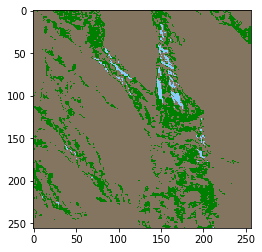

In [14]:
for i in range(256):
    for j in range(256):
        rgb[i,j,:] = np.expand_dims(np.array(lab2rgb[landcover[i,j]]),axis=0)
plt.imshow(rgb)

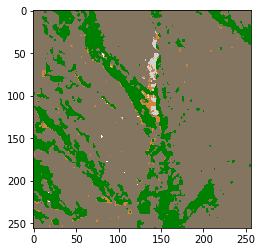

In [15]:
for i in range(256):
    for j in range(256):
        rgb[i,j,:] = np.expand_dims(np.array(lab2rgb[y_train_hr[i,j]]),axis=0)
plt.imshow(rgb)

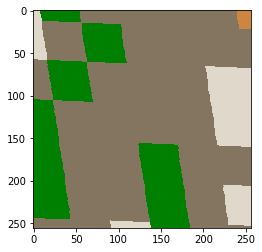

In [16]:
for i in range(256):
    for j in range(256):
        rgb[i,j,:] = np.expand_dims(np.array(lab2rgb[y_train_nlcd[i,j]]),axis=0)
plt.imshow(rgb)

In [17]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min))

In [27]:
redn = normalize(actual[:, :, 0])
greenn = normalize(actual[:, :, 1])
bluen = normalize(actual[:, :, 2])
X1 = np.dstack((redn, greenn, bluen))

In [30]:
def plot_images(src_img, gen_img, tar_img):
    #images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    #images = (images + 1) / 2.0
    #titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    
    n_samples =1
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(src_img)
    # plot generated target image
    for i in range(n_samples):
        for p in range(256):
            for q in range(256):
                rgb[p,q,:] = np.expand_dims(np.array(lab2rgb[gen_img[p,q]]),axis=0)
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(rgb)
    # plot real target image
    for i in range(n_samples):
        for p in range(256):
            for q in range(256):
                rgb[p,q,:] = np.expand_dims(np.array(lab2rgb[tar_img[p,q]]),axis=0)
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(rgb)

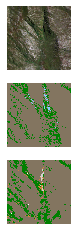

In [31]:
plot_images(X1, landcover, y_train_hr)